# 项目：分析鸢尾花种类数据

## 分析目标

此数据分析报告的目的是基于鸢尾花的属性数据，分析两种鸢尾花萼片、花瓣的长度和宽度平均值，是否存在显著性差异，让我们可以对不同种类鸢尾花的属性特征进行推断。

## 简介

原始数据`Iris.csv`包括两种鸢尾花，每种有 50 个样本，以及每个样本的一些属性，包括萼片的长度和宽度、花瓣的长度和宽度。

`Iris.csv`每列的含义如下：
- Id：样本的ID。
- SepalLengthCm：萼片的长度（单位为厘米）。
- SepalWidthCm：萼片的宽度（单位为厘米）。
- PetalLengthCm：花瓣的长度（单位为厘米）。
- PetalWidthCm：花瓣的宽度（单位为厘米）。
- Species：鸢尾花种类。

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy.stats import ttest_ind

In [3]:
original_data = pd.read_csv(r'../../数据集/原始数据/Iris.csv')

In [4]:
original_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


## 1. 数据清洗和评估

数据清洗主要有两个部分组成：结构和内容，即整齐度和干净度，结构性问题是指数据不符合"每行是一个观察值，每列是一个变量，每个单元格是一个值"的规则，内容性问题是指数据存在数据缺失、重复数据、无效数据和不一致数据等问题

### 1.1 数据结构性评估

In [5]:
original_data.sample(10)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
2,3,4.7,3.2,1.3,0.2,Iris-setosa
56,57,6.3,3.3,4.7,1.6,Iris-versicolor
98,99,5.1,2.5,3.0,1.1,Iris-versicolor
64,65,5.6,2.9,3.6,1.3,Iris-versicolor
33,34,5.5,4.2,1.4,0.2,Iris-setosa
91,92,6.1,3.0,4.6,1.4,Iris-versicolor
99,100,5.7,2.8,4.1,1.3,Iris-versicolor
76,77,6.8,2.8,4.8,1.4,Iris-versicolor
59,60,5.2,2.7,3.9,1.4,Iris-versicolor
93,94,5.0,2.3,3.3,1.0,Iris-versicolor


从随机抽取的10条数据进行观察，数据符合"每一行是一个观察值，每一列是一个变量，每一个单元格是一个值"的规则，每行表示的是一朵鸢尾花的详情，每列表示的是鸢尾花的各个变量

### 1.2 评估数据干净度

In [7]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             100 non-null    int64  
 1   SepalLengthCm  100 non-null    float64
 2   SepalWidthCm   100 non-null    float64
 3   PetalLengthCm  100 non-null    float64
 4   PetalWidthCm   100 non-null    float64
 5   Species        100 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 4.8+ KB


从输出结果来看，数据不存在缺失值  
  
从数据类型来看`Species` 应当为分类变量，因此可以把数据类型都转换为Category

#### 1.2.1 重复数据

在`cleaned_data`中，`id`是唯一标识，不应该存在重复

In [12]:
original_data["Id"].duplicated().sum()

0

统计重复数据为`0`条，故`original_data`中不存在重复数据，无需处理

#### 1.2.2 无效数据

In [14]:
original_data.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,5.471000,3.094000,2.862000,0.785000
std,29.011492,0.641698,0.476057,1.448565,0.566288
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,25.750000,5.000000,2.800000,1.500000,0.200000
50%,50.500000,5.400000,3.050000,2.450000,0.800000
75%,75.250000,5.900000,3.400000,4.325000,1.300000
max,100.000000,7.000000,4.400000,5.100000,1.800000


从输出结果来看，`cleaned_data`里不存在脱离现实意义的数值

#### 1.2.3 不一致数据

不一致数据可能存在于`Species`中，可能存在多个值指代统一个`Species`的情况

In [17]:
original_data['Species'].value_counts()

Species
Iris-setosa        50
Iris-versicolor    50
Name: count, dtype: int64

从输出结果可得，`Species`只有两种可能的值，`Iris-versicolor`和`Iris-setosa`，不存在不一致数据

### 1.2 数据清洗

#### 1.2.1 清理数据

根据前面评估部分得到的结论，我们需要进行的数据清理包括:
- 把`Species`的数据类型转换为`Category`

为了区分开经过清理的数据和原始的数据，我们创建新的变量`cleaned_data`，让它为`original_data`复制出的副本。我们之后的清理步骤都将被运用在`cleaned_data`上。

In [20]:
cleaned_data = original_data.copy()
cleaned_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [21]:
cleaned_data['Species'] = cleaned_data['Species'].astype('category')

In [22]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             100 non-null    int64   
 1   SepalLengthCm  100 non-null    float64 
 2   SepalWidthCm   100 non-null    float64 
 3   PetalLengthCm  100 non-null    float64 
 4   PetalWidthCm   100 non-null    float64 
 5   Species        100 non-null    category
dtypes: category(1), float64(4), int64(1)
memory usage: 4.3 KB


#### 1.2.2 保存数据

In [23]:
cleaned_data.to_csv(r'../../数据集/整洁数据/Cd_Iris.csv')

### 1.3 可视化数据

#### 1.3.1 数据分离

In [59]:
Iris_setosa = cleaned_data.query("Species == 'Iris-setosa'")
Iris_setosa.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [62]:
Iris_versicolor = cleaned_data.query("Species == 'Iris-versicolor'")
Iris_versicolor.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
50,51,7.0,3.2,4.7,1.4,Iris-versicolor
51,52,6.4,3.2,4.5,1.5,Iris-versicolor
52,53,6.9,3.1,4.9,1.5,Iris-versicolor
53,54,5.5,2.3,4.0,1.3,Iris-versicolor
54,55,6.5,2.8,4.6,1.5,Iris-versicolor


In [44]:
# 设置图表色盘为"pastel"
sns.set_palette("pastel")

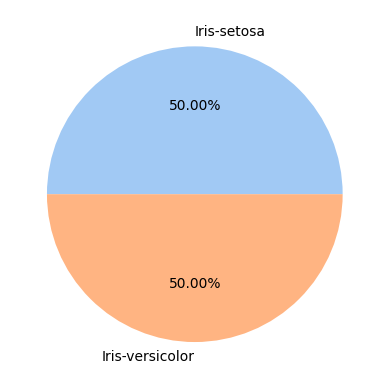

In [45]:
species = cleaned_data['Species'].value_counts()
plt.pie(species,labels=species.index,autopct='%.2f%%')
plt.show()

样本鸢尾花的种类占比持平，符合随机抽样

#### 1.3.2 鸢尾花种类萼片的长度与宽度分布

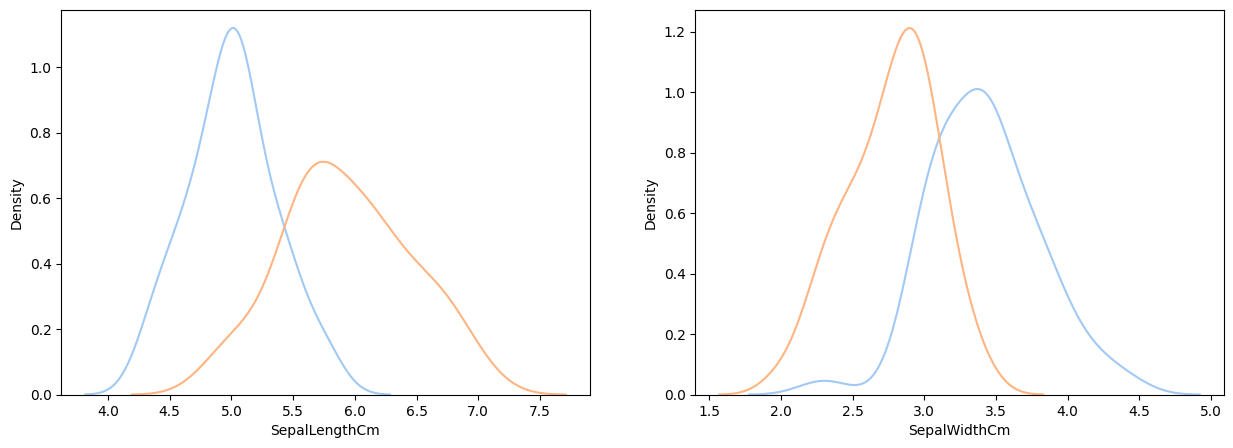

In [99]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))
sns.kdeplot(Iris_setosa['SepalLengthCm'],ax=axes[0])
sns.kdeplot(Iris_versicolor['SepalLengthCm'],ax=axes[0])
sns.kdeplot(Iris_setosa['SepalWidthCm'] ,ax=axes[1])
sns.kdeplot(Iris_versicolor['SepalWidthCm'] ,ax=axes[1])
plt.show()

`Iris_setosa`与`Iris_versicolor`的`SepalLengthCm`(萼片长度)与`SepalLengthCm`(萼片宽度)样本均大致成正态分布

#### 1.3.3 鸢尾花种类花瓣的长度与宽度分布

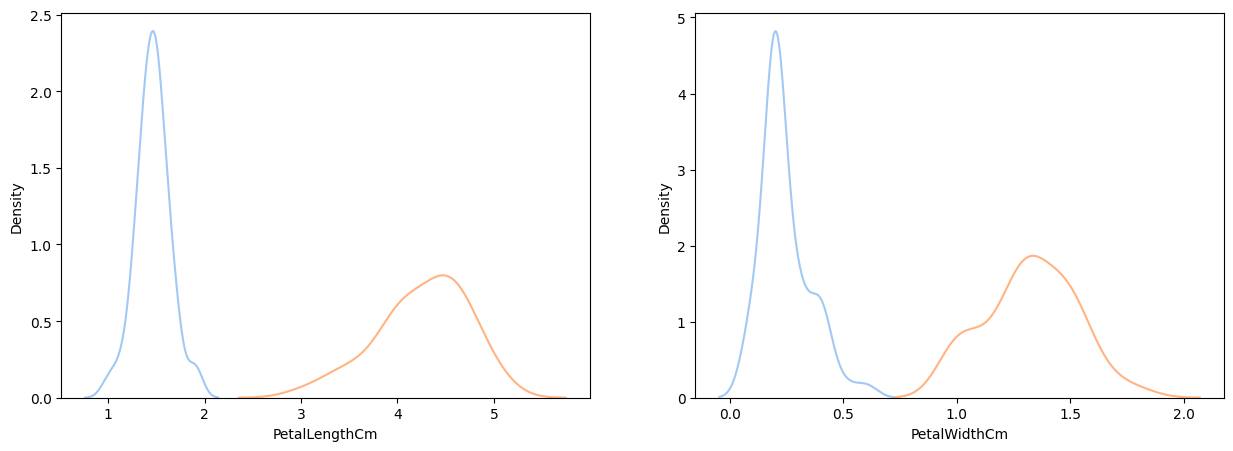

In [100]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))
sns.kdeplot(Iris_setosa['PetalLengthCm'] ,ax=axes[0])
sns.kdeplot(Iris_versicolor['PetalLengthCm'] ,ax=axes[0])
sns.kdeplot(Iris_setosa['PetalWidthCm'] ,ax=axes[1])
sns.kdeplot(Iris_versicolor['PetalWidthCm'] ,ax=axes[1])
plt.show()

`Iris_setosa`与`Iris_versicolor`的`PetalLengthCm`(花瓣长度)与`PetalWidthCm`(花瓣宽度)均样本大致成正态分布

#### 1.3.4 对比鸢尾花种类之间的各个变量

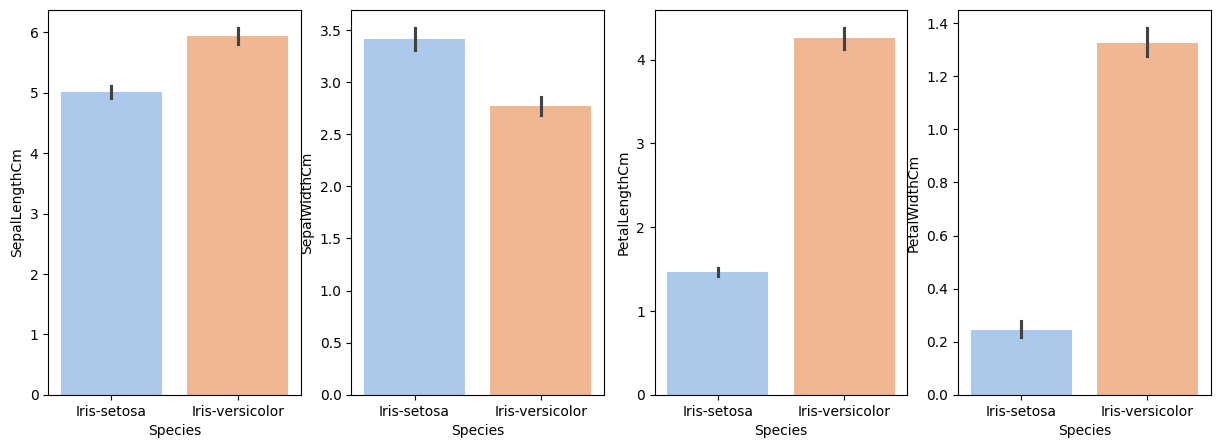

In [53]:
fig, axes = plt.subplots(1,4,figsize=(15, 5))
sns.barplot(cleaned_data, x='Species' ,y='SepalLengthCm',hue='Species',ax=axes[0])
sns.barplot(cleaned_data, x='Species' ,y='SepalWidthCm',hue='Species',ax=axes[1])
sns.barplot(cleaned_data, x='Species' ,y='PetalLengthCm',hue='Species',ax=axes[2])
sns.barplot(cleaned_data, x='Species' ,y='PetalWidthCm',hue='Species',ax=axes[3])
plt.show()

从图中可以看出，`Iris-setosa`与`Iris-versicolor`在萼片平均长度与萼片平均宽度上可能存在差异；在花瓣长度和宽度方面，可以很明显看到`Iris-setosa`与`Iris-versicolor`存在显著差异`Iris-versicolor`的鸢尾花在花瓣平均长度和平均宽度上均大于`Iris-setosa`，所以猜测假设检验的结果是，两种鸢尾花的花瓣平均长度与平均宽度有统计显著性差异。

### 1.4 数据分析

#### 1.4.1 `setosa`与`versicolor`的萼片平均长度差异分析

#### 建立假设

$H_0$:`Iris-setosa`与`Iris-versicolor`的萼片平均长度不存在显著差异  
  
$H_1$:`Iris-setosa`与`Iris-versicolor`的萼片平均长度存在显著差异

#### 确认检验是单尾还是双尾

由于我们想要检验的是两种花的萼片平均长度是否存在差异，不检验那个品种萼片长度更长，所以使用双尾检验

#### 确定显著水平

我们选择双尾检验中比较常见的数值0.05作为显著水平

#### 计算t值

In [79]:
t_test, p_value = ttest_ind(Iris_setosa['SepalLengthCm'],Iris_versicolor['SepalLengthCm'])
print(f't值为：{t_test},\np值为：{p_value}')
Significant_level = 0.05
if p_value >= 0.05:
    print('两组数据的均值没有显著差异')
else:
    print('两组数据的均值存在显著差异')

t值为：-10.52098626754911,
p值为：8.985235037487079e-18
两组数据的均值存在显著差异


#### 结论

p值小于显著水平，我们拒绝原假设，认为两种花的萼片平均长度存在显著差异

### `setosa`与`versicolor`的萼片平均宽度差异分析

#### 建立假设

$H_0$:`Iris-setosa`与`Iris-versicolor`的萼片平均宽度不存在显著差异  
  
$H_1$:`Iris-setosa`与`Iris-versicolor`的萼片平均宽度存在显著差异

#### 确定单尾检验还是双尾检验

由于我们想要检验的是两种花的萼片平均宽度是否存在差异，不检验那个品种萼片宽度更宽，所以使用双尾检验

#### 确定显著水平

我们选择双尾检验中比较常见的数值0.05作为显著水平

#### 计算t值

In [82]:
t_test, p_value = ttest_ind(Iris_setosa['SepalWidthCm'],Iris_versicolor['SepalWidthCm'])
print(f't值为：{t_test},\np值为：{p_value}')
Significant_level = 0.05
if p_value >= 0.05:
    print('两组数据的均值没有显著差异')
else:
    print('两组数据的均值存在显著差异')

t值为：9.282772555558111,
p值为：4.362239016010214e-15
两组数据的均值存在显著差异


#### 结论

p值小于显著水平，所以我们拒绝原假设，认为两种花的萼片平均宽度存在显著差异

#### 1.4.2 `setosa`与`versicolor`的花瓣平均长度差异分析

#### 建立假设

$H_0$:`Iris-setosa`与`Iris-versicolor`的花瓣平均长度不存在显著差异  
  
$H_1$:`Iris-setosa`与`Iris-versicolor`的花瓣平均长度存在显著差异

#### 确定单尾检验还是双尾检验

由于我们想要检验的是两种花的花瓣平均长度是否存在差异，不检验那个品种花瓣长度更长，所以使用双尾检验

#### 确定显著水平¶

我们选择双尾检验中比较常见的数值0.05作为显著水平

#### 计算t值

In [93]:
t_test, p_value = ttest_ind(Iris_setosa['PetalLengthCm'],Iris_versicolor['PetalLengthCm'])
print(f't值为：{t_test},\np值为：{p_value}')
Significant_level = 0.05
if p_value >= 0.05:
    print('两组数据的均值没有显著差异')
else:
    print('两组数据的均值存在显著差异')

t值为：-39.46866259397272,
p值为：5.717463758170621e-62
两组数据的均值存在显著差异


#### 结论

p值小于显著水平，所以我们拒绝原假设，认为两种花的花瓣平均长度存在显著差异

#### 1.4.3 `setosa`与`versicolor`的花瓣平均宽度差异分析

#### 建立假设

$H_0$:`Iris-setosa`与`Iris-versicolor`的花瓣平均宽度不存在显著差异  
  
$H_1$:`Iris-setosa`与`Iris-versicolor`的花瓣平均宽度存在显著差异

#### 确定单尾检验还是双尾检验¶

由于我们想要检验的是两种花的花瓣平均宽度是否存在差异，不检验那个品种花瓣宽度更宽，所以使用双尾检验

#### 确定显著水平¶

我们选择双尾检验中比较常见的数值0.05作为显著水平

#### 计算t值

In [94]:
t_test, p_value = ttest_ind(Iris_setosa['PetalWidthCm'],Iris_versicolor['PetalWidthCm'])
print(f't值为：{t_test},\np值为：{p_value}')
Significant_level = 0.05
if p_value >= 0.05:
    print('两组数据的均值没有显著差异')
else:
    print('两组数据的均值存在显著差异')

t值为：-34.01237858829048,
p值为：4.589080615710866e-56
两组数据的均值存在显著差异


#### 结论

p值小于显著水平，所以我们拒绝原假设，认为两种花的花瓣平均长度存在显著差异

## 结论

经过推断统计学的推断过程，我们可以得出，`setosa`与`versicolor`两种品种的鸢尾花在萼片和花瓣的长度平均值以及宽度的平均值，均存在具有统计显著性的差异